Vamos a ver qué tan bien ha hecho el trabajo BLS (vamos a comparar los resultados obtenidos con period_day)


ESTADO               | CONTEO     | PORCENTAJE | PORCENTAJE SIN PERIODO LARGO 
--------------------------------------------------------------------------------
Válido               | 263        | 77.5811 | 84.8387
Descartados          | 31         | 9.14454 | 10
Periodo Largo        | 29         | 8.55457 | -
Armónico             | 16         | 4.71976 | 5.16129
TOTAL_SISTEMAS       | 339        | 100 | -



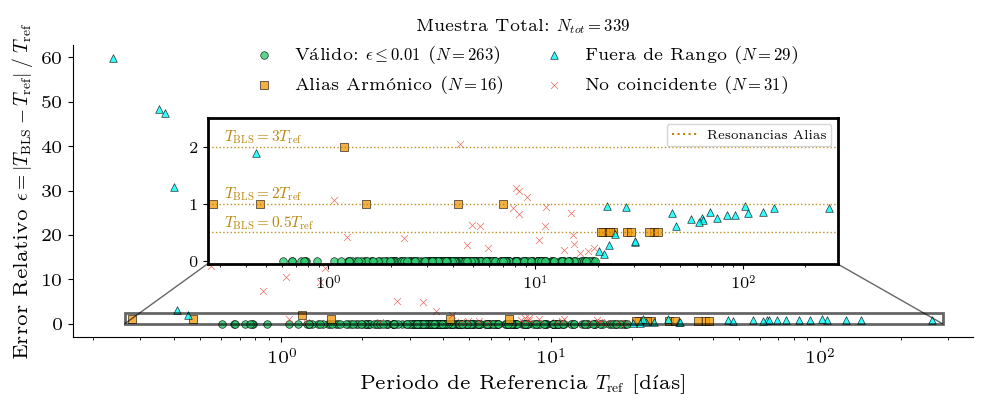

In [45]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def check_aliasing(p_calc, p_ref, eps_p):
    """Clasificación física de periodos detectados"""
    factores = {1.0: "Válido", 0.5: "Armónico", 2.0: "Armónico", 3.0: "Armónico"}
    for k, estado in factores.items():
        p_target = k * p_ref
        if p_target == 0: continue
        if abs(p_calc - p_target) / p_target <= eps_p:
            return estado

    if p_ref > 20 or p_ref <0.5:
        return "Periodo Largo"
    return "Descartados"

def obtener_datos_y_estadisticas(directorio_raiz, eps_p=0.01):
    """Procesamiento de datos y conteo"""
    resultados = []
    for root, _, files in os.walk(directorio_raiz):
        if "stitching" not in root.lower(): continue
        for f in [f for f in files if f.endswith(".json")]:
            try:
                with open(os.path.join(root, f), 'r') as file:
                    data = json.load(file)
                p_c = pd.to_numeric(data.get("bls", {}).get("period_days"), errors='coerce')
                p_r = pd.to_numeric(data.get("NEA", {}).get("NEA_period_day"), errors='coerce')
                
                if pd.notna(p_c) and pd.notna(p_r):
                    estado = check_aliasing(p_c, p_r, eps_p)
                    resultados.append({"P_ref": p_r, "Error": abs(p_c - p_r) / p_r, "Estado": estado})
            except: continue

    df = pd.DataFrame(resultados)
    if df.empty: return df, {}

    stats = df['Estado'].value_counts().to_dict()
    stats['TOTAL_SISTEMAS'] = len(df)
    for k in ["Válido", "Armónico", "Periodo Largo", "Descartados"]: stats.setdefault(k, 0)
    return df, stats

def plot_validacion_fisica_refinado(df, stats=None, eps_p=0.01):
    """Genera el gráfico final"""
    if df.empty: return

    plt.rcParams.update({
        "text.usetex": False,            
        "font.family": "serif",
        "font.serif": ["Latin Modern Roman", "Computer Modern Serif", "serif"],
        "mathtext.fontset": "cm",        
        "axes.labelweight": "normal"
    })

    fig, ax = plt.subplots(figsize=(10, 4))

    estilos = {
        'Válido':       {'c': '#2ecc71', 'm': 'o', 's': 30, 'label': rf'Válido: $\epsilon \leq {eps_p:.2f}$ ($N={stats["Válido"]}$)', 'edg': 'k'},
        'Armónico':     {'c': '#f39c12', 'm': 's', 's': 30, 'label': rf'Alias Armónico ($N={stats["Armónico"]}$)', 'edg': 'k'},
        'Periodo Largo':{'c': '#00ffff', 'm': '^', 's': 30, 'label': rf'Fuera de Rango ($N={stats["Periodo Largo"]}$)', 'edg': 'k'},
        'Descartados':  {'c': '#e74c3c', 'm': 'x', 's': 25, 'label': rf'No coincidente ($N={stats["Descartados"]}$)', 'edg': None}
    }

    def _scatter_layer(target_ax, is_legend=False):
        for est, cfg in estilos.items():
            mask = df['Estado'] == est
            target_ax.scatter(df.loc[mask, 'P_ref'], df.loc[mask, 'Error'], 
                              c=cfg['c'], marker=cfg['m'], s=cfg['s'], 
                              edgecolors=cfg['edg'], alpha=0.8, linewidths=0.5,
                              label=cfg['label'] if is_legend else "")
        target_ax.set_xscale('log')

    _scatter_layer(ax, is_legend=True)
    ax.set_xlabel(r'Periodo de Referencia $T_{\mathrm{ref}}$ [días]', fontsize=14)
    ax.set_ylabel(r'Error Relativo $\epsilon = |T_{\mathrm{BLS}} - T_{\mathrm{ref}} | \; /\; T_{\mathrm{ref}}$', fontsize=14)

    axins = ax.inset_axes([0.15, 0.25, 0.7, 0.5])
    _scatter_layer(axins)



    axins.set_xlim(df['P_ref'].min() * 1.1, df['P_ref'].max() * 1.1) 
    axins.set_ylim(-0.05, 2.5)
    axins.tick_params(labelsize=11)

    plt.rcParams.update({
    "xtick.labelsize": 13,
    "ytick.labelsize": 13
})
    
    for spine in axins.spines.values():
        spine.set_linewidth(2.0)
        
    line_alias = mlines.Line2D([], [], color='darkgoldenrod', linestyle=':', label='Resonancias Alias')
    for val, lbl in zip([0.5, 1.0, 2.0], [r'$T_{\mathrm{BLS}} = 0.5 T_{\mathrm{ref}}$', r'$T_{\mathrm{BLS}} = 2T_{\mathrm{ref}}$', r'$T_{\mathrm{BLS}} = 3T_{\mathrm{ref}}$']):
        axins.axhline(y=val, color='darkgoldenrod', ls=':', lw=1, alpha=0.9)
        axins.text(axins.get_xlim()[0]*1.2, val+0.1, lbl, color='darkgoldenrod', fontsize=11)

    indicator = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)
    indicator.rectangle.set_linewidth(2.0)


    handles, labels = ax.get_legend_handles_labels()

    total = stats['TOTAL_SISTEMAS']
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol = 2, frameon=False, fontsize=12, 
              title=f"Muestra Total: $N_{{tot}}={total}$", title_fontsize = 12)

    axins.legend(handles=[line_alias], loc='upper right', frameon=True, fontsize=9, facecolor='white', framealpha=0.8)

    
    # Forzamos solo los conectores de las esquinas inferiores
    indicator.connectors[0].set_visible(True) 
    indicator.connectors[1].set_visible(False)
    indicator.connectors[2].set_visible(True)
    indicator.connectors[3].set_visible(False)
    
    plt.subplots_adjust(
    bottom=0.15,   
    left=0.08,     
    right=0.98,    
    hspace=0.0,
    wspace=0.0
)
    ax.spines[['top', 'right']].set_visible(False)
    plt.savefig('val_period_alias', dpi = 300)
    plt.show()

# --- EJECUCIÓN ---
ruta = r"C:\Users\jorge\Desktop\TE+\tess\resultados"
df_p, stats = obtener_datos_y_estadisticas(ruta)

if not df_p.empty:
    print("\n" + "="*80)
    print(f"{'ESTADO':<20} | {'CONTEO':<10} | {'PORCENTAJE'} | {'PORCENTAJE SIN FUERA DE RANGO'} ")
    print("-" * 80)
    total = stats['TOTAL_SISTEMAS']
    largo = stats['Periodo Largo']
    for k, v in stats.items():
        if k in {'Periodo Largo', 'TOTAL_SISTEMAS'}: #Periodo Largo = Fuera de Rango
            print(f"{k:<20} | {v:<10} | {100.0*v/total:.6g} | -")
        else:
            print(f"{k:<20} | {v:<10} | {100.0*v/total:.6g} | {100.0*v/(total-largo):.6g}")
    print("="*80 + "\n")

plot_validacion_fisica_refinado(df_p, stats)


In [ ]:
import shutil

def exportar_resultados_validos(directorio_raiz, nombre_carpeta="resultados_validos", eps_p=0.01):
    """
    Filtra y copia archivos JSON cuyo error relativo cumple con el umbral de validación.
    """
    ruta_destino = os.path.join(os.path.dirname(directorio_raiz), nombre_carpeta)
    
    if not os.path.exists(ruta_destino):
        os.makedirs(ruta_destino)
        print(f"Carpeta creada en: {ruta_destino}")

    conteo_copiados = 0
    
    for root, _, files in os.walk(directorio_raiz):
        if "stitching" not in root.lower(): continue
        for f in [f for f in files if f.endswith(".json")]:
            ruta_origen = os.path.join(root, f)
            try:
                with open(ruta_origen, 'r') as file:
                    data = json.load(file)
                
                p_c = pd.to_numeric(data.get("bls", {}).get("period_days"), errors='coerce')
                p_r = pd.to_numeric(data.get("NEA", {}).get("NEA_period_day"), errors='coerce')

                if pd.notna(p_c) and pd.notna(p_r):
                    # Condición de validez: error relativo <= eps_p
                    error_relativo = abs(p_c - p_r) / p_r
                    if error_relativo <= eps_p:
                        # Copia preservando metadatos
                        shutil.copy2(ruta_origen, os.path.join(ruta_destino, f))
                        conteo_copiados += 1
            except Exception as e:
                print(f"Error procesando {f}: {e}")
                continue
                
    print(f"Exportación finalizada: {conteo_copiados} archivos copiados a '{nombre_carpeta}'.")



exportar_resultados_validos(ruta)

In [33]:
stats.keys()


dict_keys(['Válido', 'Descartados', 'Periodo Largo', 'Armónico', 'TOTAL_SISTEMAS'])